In [48]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
RESULT_DIR = "../results/"
RESULT_FILE = "Winter2025_compute_costs.csv"
INSTRUCTOR_ID = "4721d6f7"
PROJECT_ID = "4721d6f7-2c22-4a6c-9227-499a9b0a40b0"
df = pd.read_csv(RESULT_DIR + RESULT_FILE)
print(df.columns)



Index(['id', 'time', 'cost', 'period_start', 'period_end', 'cost_per_hour',
       'cost_so_far', 'service', 'description', 'invoice_id', 'project_id',
       'notes', 'filter', 'balance', 'machineType', 'compute_server_id',
       'diskSizeGb'],
      dtype='object')


                              project_id       cost  short_id
25  e869b46b-acbd-4e53-9722-d41f41348050  30.591685  e869b46b
0   02dca5a6-92da-4805-b9d9-9d5076ba3a94  23.421918  02dca5a6
13  7cc205d7-4d68-4202-827c-0d03275ac596  22.656076  7cc205d7
15  8b4ffd18-bb23-4915-a5b5-e36d4c1735b9  21.471554  8b4ffd18
18  9e7b601b-4d71-44bf-87ac-2951de80914c  16.732047  9e7b601b


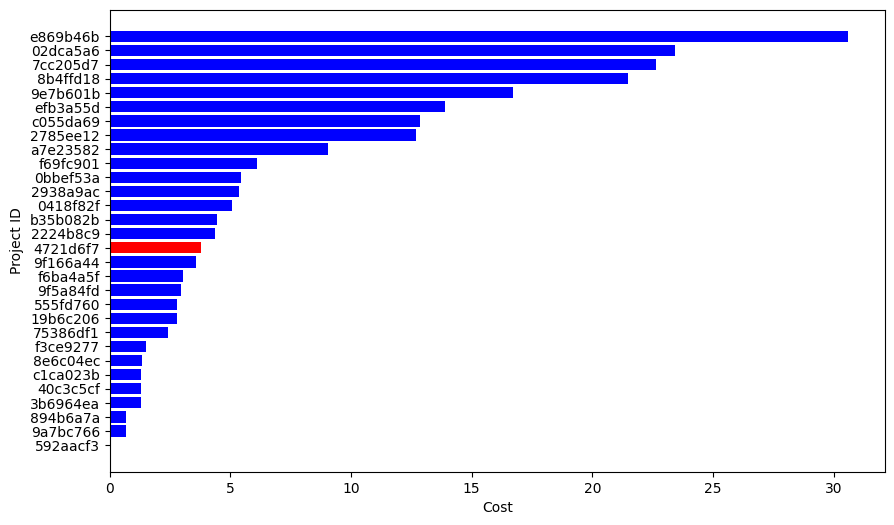

In [96]:
#group by project_id
# keep only the sum of the cost and diskSizeGb, machineType, project_id
breakdown_1 = df.groupby(['project_id']).agg({'cost': 'sum'})
# convert the index to a column
breakdown_1 = breakdown_1.reset_index().sort_values(by='cost', ascending=False)
# add column "short_id"
breakdown_1['short_id'] = breakdown_1['project_id'].str[:8]
print(breakdown_1.head())
# add column "colour" with RGBA values of blue
breakdown_1['colour'] = 'blue'
# colour the bar of the instructor_id
breakdown_1.loc[breakdown_1['short_id'] == INSTRUCTOR_ID, 'colour'] = 'red'

plt.figure(figsize=(10, 6))
# create horizontal barplot of the cost by project_id 
sns.barplot(x='cost', y='short_id', data=breakdown_1)

# color the bars
for i, row in breakdown_1.iterrows():
    plt.barh(row['short_id'], row['cost'], color=row['colour'])

# rename the y-axis to "Project ID"
plt.ylabel("Project ID")
# rename the x-axis to "Cost"
plt.xlabel("Cost")
# save the plot
# figure size 10x6

plt.savefig(RESULT_DIR + "Winter2025_compute_costs_breakdown_1.png")
plt.show()

# export the breakdown_1 to a csv file
breakdown_1 = breakdown_1.drop(columns=['colour', 'short_id'])
breakdown_1.to_csv(RESULT_DIR + "Winter2025_compute_costs_breakdown_1.csv")


   diskSizeGb  vCPU        cost
6         750    60  116.973697
1          20     8   58.400049
3          50    32   40.122345
4          75    32    6.721039
2          30     4    0.962925


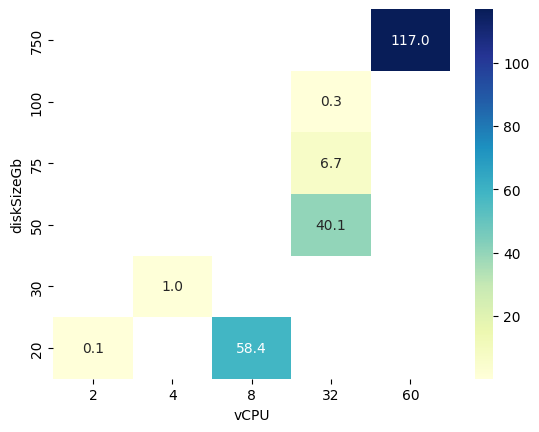

In [97]:
# group by diskSizeGb, machineType
# keep only the sum of the cost and diskSizeGb, machineType
df['vCPU'] = df['machineType'].str.split('-').str[2]
df['vCPU'] = df['vCPU'].astype(int)
breakdown_2 = df.groupby(['diskSizeGb', 'vCPU']).agg({'cost': 'sum'})

breakdown_2 = breakdown_2.reset_index().sort_values(by='cost', ascending=False)
# integerize the vCPU

print(breakdown_2.head())
# log scale the diskSizeGb
breakdown_2['diskSizeGb'] = breakdown_2['diskSizeGb'].astype(int)
breakdown_2['cost'] = breakdown_2['cost'].astype(float)
# create heat map of the cost by diskSizeGb, machineType
breakdown_2 = breakdown_2.pivot(index='diskSizeGb', columns='vCPU', values='cost')
# sort the index
breakdown_2 = breakdown_2.sort_index(ascending=False)

sns.heatmap(data=breakdown_2, annot=True, fmt=".1f", cmap='YlGnBu')

# save the plot
plt.savefig(RESULT_DIR + "Winter2025_compute_costs_breakdown_2.png")
plt.show()

breakdown_2.to_csv(RESULT_DIR + "Winter2025_compute_costs_breakdown_2.csv")



In [84]:
# Calculate the total cost
total_cost = breakdown_2.sum().sum()
print(f"Total cost: {total_cost}")


Total cost: 223.54365713319999


In [140]:
# Create markdown report from the plots and csv files
import os
with open(RESULT_DIR + "Winter2025_compute_costs_report.md", "w") as md: 
    # add title
    md.write("# Winter 2025 Compute Costs Report\n")
    # Instructor ID and Project ID as paragraphs using html
    # custom font size: 24px
    md.write(f"<p style='font-size: 18px;'>Instructor ID: {INSTRUCTOR_ID}</p>\n")
    md.write(f"<p style='font-size: 18px;'>Project ID: {PROJECT_ID}</p>\n")
    # add total cost as a paragraph bolded
    md.write(f"<p style='font-size: 18px; font-weight: bold;'>Total cost: {total_cost}</p>\n\n")
    # add figure using html
    # Use absolute paths for images and add a blank line after each
    md.write(f"<img src='{os.path.abspath(RESULT_DIR)}/Winter2025_compute_costs_breakdown_1.png' alt='Winter2025_compute_costs_breakdown_1' style='width: 100%; height: auto;'>\n\n")   
    md.write(f"<img src='{os.path.abspath(RESULT_DIR)}/Winter2025_compute_costs_breakdown_2.png' alt='Winter2025_compute_costs_breakdown_2' style='width: 80%; height: auto;'>\n\n")
    
    # add markdown table as md
    # add page break before the table
    md.write("<div style='page-break-before: always;'></div>\n\n")
    md.write("----\n\n")
    md.write(breakdown_1.to_markdown())
    md.write("\n\n")
    md.write("----\n\n")
    md.write(breakdown_2.to_html())



In [138]:
def convert_md_to_pdf(md_file, pdf_file):
    import subprocess
    
    # Construct the pandoc command to read html in markdown file    
    cmd = [
        'pandoc',
        md_file,
        '-o', pdf_file,
        '--pdf-engine=xelatex',
        '-V', 'geometry:margin=1in',
        '--variable', 'mainfont=DejaVu Sans',
        '--highlight-style=tango',
        '--from', 'markdown+raw_html',  # Enable HTML parsing
        '--standalone',
        '-V', 'colorlinks=true',
        '-V', 'linkcolor=blue',
    ]

    # Execute the command
    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print("PDF generated successfully!")
    except subprocess.CalledProcessError as e:
        print(f"Error generating PDF: {e.stderr}")

# Convert the file
md_file = RESULT_DIR + "Winter2025_compute_costs_report.md"
pdf_file = RESULT_DIR + "Winter2025_compute_costs_report.pdf"
convert_md_to_pdf(md_file, pdf_file)

PDF generated successfully!


In [114]:
!sudo apt-get install pandoc texlive-xetex -y

[sudo] password for alice: 


In [123]:
!pip install tabulate


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
